# HW2: Exploratory Data Analysis




<span style="color:green">    - Antônio Luís Sombra de Medeiros</span>  
<span style="color:green"> - João Marcos Amorim </span>  
<span style="color:green">     - Renato Aranha</span> 




Guidelines:

- What question do you want to answer?

    
- The classification of Cartola FC follows the table of classification of Brasileirão?

   <span style="color:blue">  
A: We rebuilt the final classification of the championship following its criteria of scoring the same and built the classification after the last of the Brasileirão by the total points made by the club in Cartola FC.  </span>
       
       
- Where have you obtained the data?

   <span style="color:blue"> A: The scraped data from the official Cartola [website] can be found [here]:</span>
    
    
- How were your data manipulation and cleaning?

 <span style="color:blue"> A: We emphasize these aspects on the notebook body </span>
    
    
- Visualize your data from multiple perspectives and indicate if you found outliers, patterns, trends.

  <span style="color:blue"> A: Graphs were created to help understand the variation in player's score and price per position and per year, helping to understand if there was a significant change in the years and we checked the variation of scores and price per position. </span>


- Indicate if your visualizations help you to answer the questions or if you have a more clear idea what path you should follow to corroborate your hypothesis. 


- Give a conclusion of your analysis. 


[website]: http://globoesporte.globo.com/cartola-fc/
[here]: https://github.com/thevtm/CartolaFCDados

# 0. DATA

* Our data can be found at: [https://github.com/thevtm/CartolaFCDados](https://github.com/thevtm/CartolaFCDados)  
It's the record from 2014 to 2017 of Cartola Data (the fantasy game)  


* We have information from players,teams, games and "scouts", which are points for what happened in each game. For example:  
 * We have data for how many goals a players did in a game, how many goals the goalkeeper of each team avoided...


* We basically work with 6 csvs (for each year from 2014 to 2017)


    1. Atletas.csv   (Data of each player)
    2. Clubes.csv    (Data of each Team)
    3. Partidas.csv  (Data of each game)
    4. Posicoes.csv  (Table with all positions possible for a player)
    5. Scouts.csv    (Game data and observations, points etc..)
    6. Status.csv    (Table with all the possible status for a player - Suspenso, Contundido, etc. - )
    
    
    
    
##### METADATA



For Atletas csv:

| Field   | Description |
| ------  | -----------|
| ID       | ID of player.|
| Apelido  | How player is called (nickname) |
| ClubeID  | ID of players' team |
| PosicaoID| ID of Players' position in field (1 = goalkepper,2 = defense,..., 4 = midfielder, 5= attacker, 6 = coach) |
| Ano      | Year the player was playing for this team and in this position |


For Clubes csv:

| Field    | Description|
| ------   | -----------|
| ID       | Team's ID  |
| Nome     | Team's name|
|Abreviacao| Team's Acronym  |
| Slug     | Team's slug |


For Partidas.csv:

| Field        | Description                        |
| ------       | -----------                        |
| Ano          | Game's Year                        |
| CasaID       | Home Team's ID                     |
| ID           | Game's ID                          |
| PlacarCasa   | Number of goals of home team      |
| PlacarVisitante| Number of goals of visiting team |
| Resultado     | Winner of game                    |
| Rodada        | Championship's Round number (for that game) |
| VisitanteID   | Visitor Team's ID                 |


For Posicoes.csv:

| Field    | Description|
| ------   | -----------|
| ID       | Position's ID  |
| Nome     | Position's name|
|Abreviacao| Position's Acronym  |


For Scouts.csv:  <span style="color:red">JOÃO, COMPLETA ISSO AQUI, SE TU É O ENTENDEDOR...</span>

| Field       | Description|
| ------      | -----------|
|Rodada       | Round      |
|ClubeID      | Team's ID  |
|AtletaID     | Players' ID|
|Participou   | If player played on that game or not|
|Pontos       | Number of Cartola points for that game  |
|PontosMedia  | Média de pontos do atleta até esta rodada (inclue rodada atual)  |
|Preco        | Preço do atleta nesta rodada  |
|PrecoVariacao|  Variação do preço da rodada passada para esta |
|FS           | Faltas sofridas  |
|PE           |Passes errados  |
|A            | Assistências |
|FT           | Finalizações na trave  |
|FD           | Finalizações defendidas  |
|FF           | Finalizações para fora  |
|G            | Gols  |
|I            | Impedimentos  |
|PP           | Penaltis perdidos  |
|RB           | Roubadas de bola  |
|FC           | Faltas cometidas  |
|GC           | Gols contras  |
|CA           | Cartões Amarelos  |
|CV           | Cartões Vermelhos  |
|SG           | Jogo sem sofrer gols |
|DD           | Defesas dificeis  |
|DP           | Defesa de penaltis |
|GS           | Gols sofridos  |
|Ano          | Year  |
- **Rodada**: Rodada em que o scout ocorreu
- **ClubeID**: ID do clube do atleta
- **AtletaID**: ID do atleta
- **Participou**: `TRUE` se o atleta participou do jogo, `FALSE` se ficou no banco
- **Pontos**: Pontuação do atleta nesta rodada
- **PontosMedia**: Média de pontos do atleta até está rodada (inclue rodada atual)
- **Preco**: Preço do atleta nesta rodada
- **PrecoVariacao**: Variação do preço da rodada passada para está
- **FS**: Faltas sofridas
- **PE**: Passes errados
- **A**: Assistências
- **FT**: Finalizações na trave
- **FD**: Finalizações defendidas
- **FF**: Finalizações para fora
- **G**: Gols
- **I**: Impedimentos
- **PP**: Penaltis perdidos
- **RB**: Roubadas de bola
- **FC**: Faltas cometidas
- **GC**: Gols contras
- **CA**: Cartões Amarelos
- **CV**: Cartões Vermelhos
- **SG**: Jogo sem sofrer gols
- **DD**: Defesas dificeis
- **DP**: Defesa de penaltis
- **GS**: Gols sofridos



For Status.csv:


| Field    | Description|
| ------   | -----------|
| ID       | Status's ID  |
| Nome     | Status's name|



# 1. LOADING DATA

In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
sns.set(color_codes=True)


import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
cwd = os.getcwd()
cwd

'/dados/home/joaomarcosest/foundations_of_data_science'

### MERGING DATA FOR ALL YEARS (2014-2017)

In [3]:
atletas_all_years = pd.DataFrame()
clubes_all_years = pd.DataFrame()
partidas_all_years = pd.DataFrame()
posicoes_all_years = pd.DataFrame()
scouts_all_years = pd.DataFrame()
status_all_years = pd.DataFrame()


for i in range(2014, 2018):
    
    path_atl = os.path.join(cwd, str(i)+"/Atletas.csv")    
    path_club = os.path.join(cwd, str(i)+"/Clubes.csv")    
    path_part = os.path.join(cwd, str(i)+"/Partidas.csv")    
    path_pos = os.path.join(cwd, str(i)+"/Posicoes.csv")   
    path_sct = os.path.join(cwd, str(i)+"/Scouts.csv")    
    path_stts = os.path.join(cwd, str(i)+"/Status.csv")
    
    atletas = pd.read_csv(path_atl)
    atletas['Ano'] = i
    clubes = pd.read_csv(path_club)
    #clubes['Ano'] = i
    partidas = pd.read_csv(path_part)
    partidas['Ano'] = i
    posicoes = pd.read_csv(path_pos)
    #posicoes['Ano'] = i
    scouts = pd.read_csv(path_sct)
    scouts['Ano'] = i
    status = pd.read_csv(path_stts)
    #status['Ano'] = i
    
    atletas_all_years = atletas_all_years.append(atletas)
    clubes_all_years = clubes_all_years.append(clubes).drop_duplicates()
    partidas_all_years = partidas_all_years.append(partidas)
    posicoes_all_years = posicoes_all_years.append(posicoes).drop_duplicates()
    scouts_all_years = scouts_all_years.append(scouts)
    status_all_years = status_all_years.append(status).drop_duplicates()

### View merged tables with all years

In [4]:
partidas_all_years.head()

,Ano,CasaID,ID,PlacarCasa,PlacarVisitante,Resultado,Rodada,VisitanteID
0,2014,262,179872,0.0,0.0,Empate,1,290
1,2014,266,179873,3.0,0.0,Casa,1,316
2,2014,276,179874,3.0,0.0,Casa,1,263
3,2014,277,179875,1.0,1.0,Empate,1,292
4,2014,293,179876,1.0,0.0,Casa,1,284


In [5]:
clubes_all_years.head()

,ID,Nome,Abreviacao,Slug
0,262,Flamengo,FLA,flamengo
1,263,Botafogo,BOT,botafogo
2,264,Corinthians,COR,corinthians
3,265,Bahia,BAH,bahia
4,266,Fluminense,FLU,fluminense


# 2. DATA CLEANING AND MANIPULATION

In this stage we create functions to generate consolidated dataframes with games and teams. 
We noticed that we have duplicated observations for Sport Club (SPO, which is also SPT) and so we removed these data from our dataframe.
Also we generate a classification table, adding the points for each victory (3 points), tie (1 point) and loss(0 points) to each teams' scores.

In [6]:
def gera_partidas_com_clubes(partidas_all_years, clubes_all_years):
    partidas_all_years = partidas_all_years.merge(clubes_all_years[['ID','Abreviacao']], how='inner', left_on='CasaID',\
                         right_on='ID')
    partidas_all_years = partidas_all_years.merge(clubes_all_years[['ID','Abreviacao']], how='inner', left_on='VisitanteID',\
                         right_on='ID')
    partidas_all_years = partidas_all_years.drop(labels=['ID_y','ID'], axis = 1)
    partidas_com_clubes = partidas_all_years.rename(columns={'ID_x':'ID_partida','Abreviacao_x':'abrev_clube_casa','Abreviacao_y':'abrev_clube_fora'})
    return partidas_com_clubes

def remove_erros_SPO(partidas_com_clubes):
    a = partidas_com_clubes.copy().drop_duplicates()
    temp = pd.DataFrame(a.groupby(['ID_partida'])['ID_partida'].count())
    temp2 = temp[temp.ID_partida == 2]
    
    a = a[(a.ID_partida.isin(temp2.index))]
    a = a[(a.abrev_clube_casa == 'SPO') | (a.abrev_clube_fora == 'SPO')]
    
    final = partidas_com_clubes[~partidas_com_clubes.index.isin(a.index)]
    partidas_com_clubes_corrigido = final.drop_duplicates()
    
    return partidas_com_clubes_corrigido

def adiciona_pontuacao(partidas_com_clubes_corrigido):
    def pts_casa(casa, fora):
        if casa > fora:
            a = 3
        elif casa < fora:
            a = 0
        else:
            a = 1
        return a

    def pts_fora(casa, fora):
        if casa > fora:
            a = 0
        elif casa < fora:
            a = 3
        else:
            a = 1
        return a
    
    a = partidas_com_clubes_corrigido.copy().drop_duplicates().reset_index()
    a['pts_casa'] = a.apply(lambda x: pts_casa(x.PlacarCasa, x.PlacarVisitante), axis=1)
    a['pts_fora'] = a.apply(lambda x: pts_fora(x.PlacarCasa, x.PlacarVisitante), axis=1)
    
    partidas_com_pontuacao = a
    
    return partidas_com_pontuacao

def gera_classificacao(partidas_com_pontuacao):
    b = partidas_com_pontuacao.copy()
    casa = pd.DataFrame(b.groupby(['Ano','abrev_clube_casa'])['pts_casa'].sum())
    fora = pd.DataFrame(b.groupby(['Ano','abrev_clube_fora'])['pts_fora'].sum())
    tabela = pd.concat([casa, fora], axis=1)
    tabela['pts_total'] = tabela.pts_casa + tabela.pts_fora
    tabela = tabela.reset_index().sort_values(by=['Ano','pts_total'], ascending = [True, False])
    return tabela

In [7]:
partidas_com_clubes = gera_partidas_com_clubes(partidas_all_years, clubes_all_years).drop_duplicates()

partidas_com_clubes_corrigido = remove_erros_SPO(partidas_com_clubes)

partidas_com_pontuacao = adiciona_pontuacao(partidas_com_clubes_corrigido)

tabela = gera_classificacao(partidas_com_pontuacao)

tabela

,Ano,abrev_clube_casa,pts_casa,pts_fora,pts_total
8,2014,CRU,47,33,80
17,2014,SAO,39,31,70
6,2014,COR,42,27,69
14,2014,INT,45,24,69
2,2014,CAM,41,21,62
11,2014,FLU,39,22,61
13,2014,GRE,40,21,61
3,2014,CAP,35,19,54
16,2014,SAN,33,20,53
10,2014,FLA,35,17,52


This tables represents the final scores/classification for each years' championship

In [8]:
#Games(Matches) tables without duplicated values

partidas_com_clubes_corrigido

,Ano,CasaID,ID_partida,PlacarCasa,PlacarVisitante,Resultado,Rodada,VisitanteID,abrev_clube_casa,abrev_clube_fora
0,2014,262,179872,0.0,0.0,Empate,1,290,FLA,GOI
2,2015,262,190387,4.0,1.0,Casa,34,290,FLA,GOI
4,2014,266,180066,2.0,0.0,Casa,13,290,FLU,GOI
6,2015,266,190326,2.0,0.0,Casa,28,290,FLU,GOI
8,2014,276,180145,3.0,0.0,Casa,31,290,SAO,GOI
10,2015,276,190233,0.0,3.0,Visitante,19,290,SAO,GOI
12,2014,277,179998,2.0,0.0,Casa,25,290,SAN,GOI
14,2015,277,190355,3.0,1.0,Casa,31,290,SAN,GOI
16,2014,293,180179,1.0,0.0,Casa,37,290,CAP,GOI
18,2015,293,190261,3.0,0.0,Casa,21,290,CAP,GOI


In [9]:
partidas_com_clubes_corrigido.to_csv('partidas_all_years.csv', sep='\t')

In [10]:
atletas_all_years = atletas_all_years.drop_duplicates(['ID','Ano']) 

In [11]:
scouts_all_years.shape

(125016, 27)

### Adding player name, team and position

In [12]:
scouts_all_years = scouts_all_years.merge(atletas_all_years[['ID','Apelido','PosicaoID','Ano']], left_on=['AtletaID','Ano'],\
                         right_on=['ID','Ano'],how = 'inner')
print(scouts_all_years.shape)
scouts_all_years = scouts_all_years.drop_duplicates()
print(scouts_all_years.shape)
scouts_all_years = scouts_all_years.merge(posicoes_all_years[['ID','Abreviacao']], left_on = 'PosicaoID',right_on = 'ID')
print(scouts_all_years.shape)
scouts_all_years = scouts_all_years.drop(labels=['ID_y','ID_x'], axis = 1)

(125016, 30)
(125016, 30)
(125016, 32)


In [13]:
scouts_all_years.columns

Index(['Rodada', 'ClubeID', 'AtletaID', 'Participou', 'Pontos', 'PontosMedia',
       'Preco', 'PrecoVariacao', 'FS', 'PE', 'A', 'FT', 'FD', 'FF', 'G', 'I',
       'PP', 'RB', 'FC', 'GC', 'CA', 'CV', 'SG', 'DD', 'DP', 'GS', 'Ano',
       'Apelido', 'PosicaoID', 'Abreviacao'],
      dtype='object')

### Droping players that din't player the match

In [14]:
print('Tamanho antes de deixar apenas quem jogou')
print(scouts_all_years.shape)
jogaram_all_years = scouts_all_years[scouts_all_years.Participou==True]
print('Tamanho depois de deixar apenas quem jogou')
print(jogaram_all_years.shape)

Tamanho antes de deixar apenas quem jogou
(125016, 30)
Tamanho depois de deixar apenas quem jogou
(43927, 30)


# Linear Regression price and points by positions

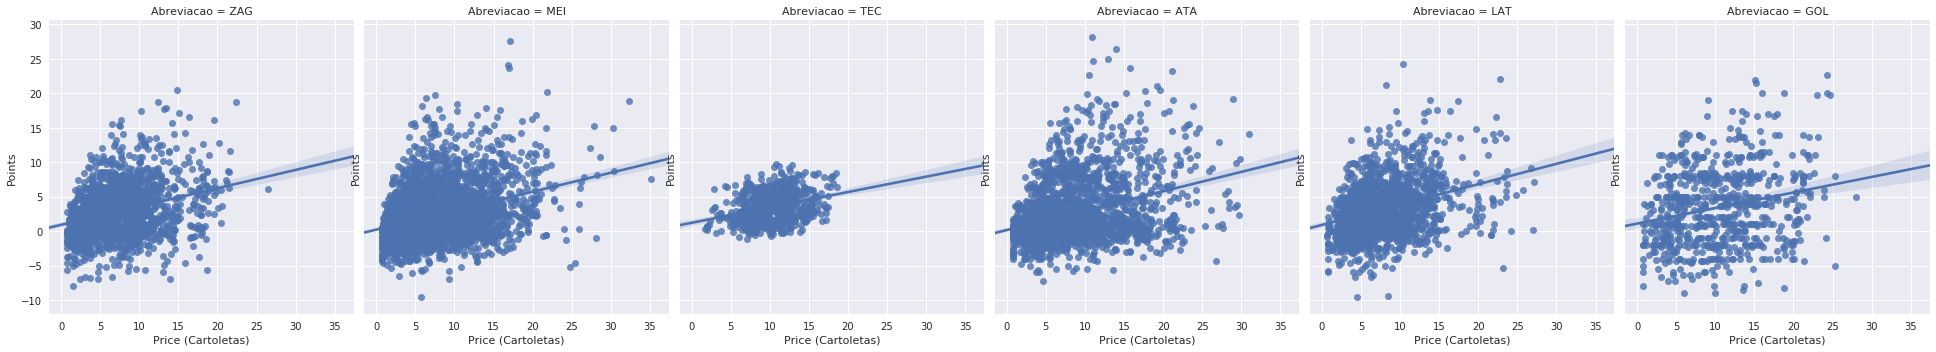

In [15]:
#fig, ax = plt.subplots()
#fig.set_size_inches(16,10)
plt.figure(figsize=(24,4))
vis = sns.lmplot(x="Preco", y="Pontos", data=jogaram_all_years.sample(10000),col='Abreviacao',legend=True,fit_reg=True,aspect=0.9)
#vis.axes.set_title('Scatter plot of points by price',fontsize=20)
#vis.tick_params(labelsize=15)
vis.set(xlabel='Price (Cartoletas)', ylabel='Points')
plt.show()

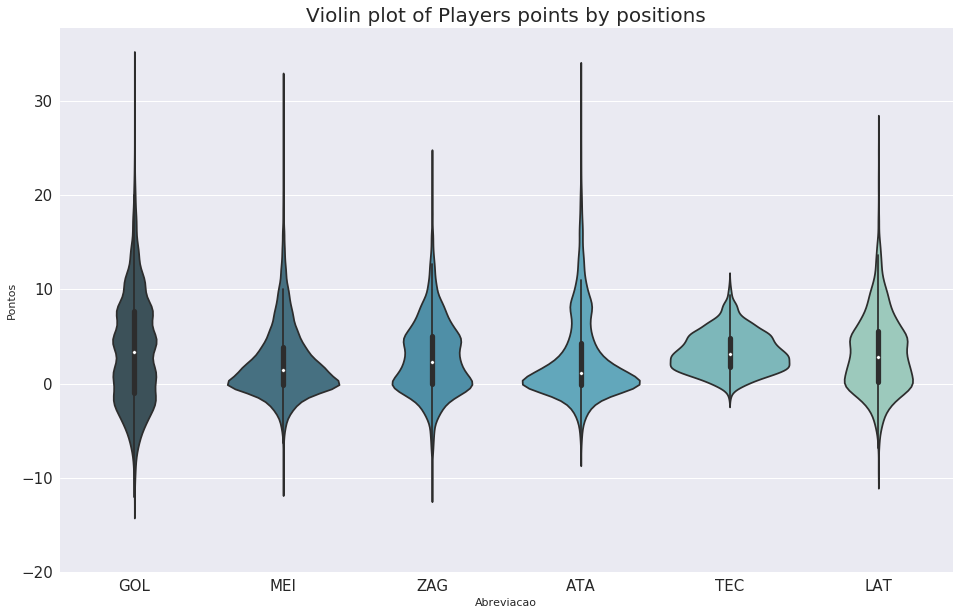

In [16]:
fig, ax = plt.subplots()
fig.set_size_inches(16,10)
vis = sns.violinplot(data = jogaram_all_years, x='Abreviacao', y="Pontos", palette="GnBu_d")
vis.set(yticks=np.arange(-20,40,10))
vis.axes.set_title('Violin plot of Players points by positions',fontsize=20)
vis.tick_params(labelsize=15)
plt.show()


In [17]:
scouts_all_years.Preco.describe()

count    125016.000000
mean          5.608481
std           4.580025
min           0.710000
25%           2.000000
50%           4.140000
75%           7.940000
max          35.180000
Name: Preco, dtype: float64

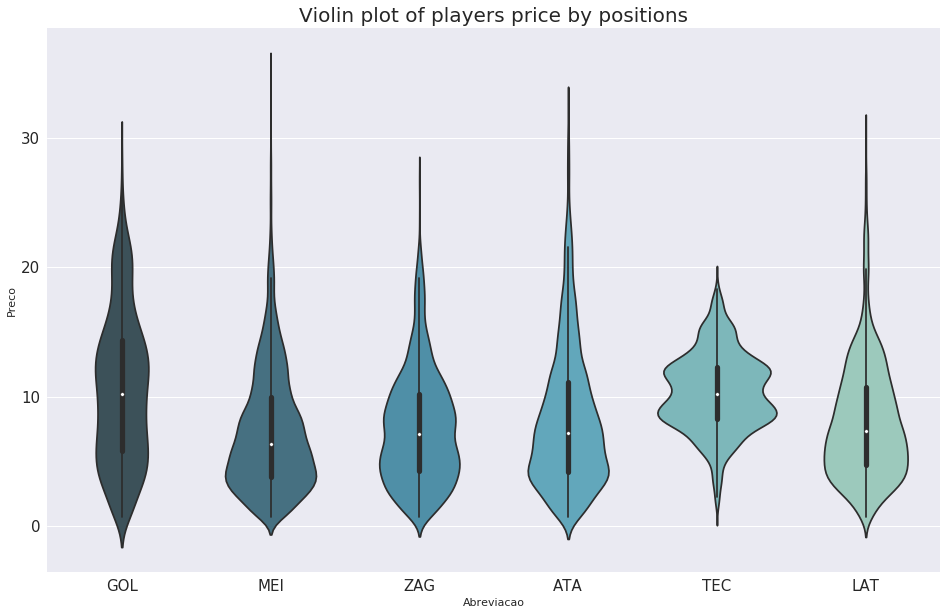

In [18]:
fig, ax = plt.subplots()
fig.set_size_inches(16,10)
vis = sns.violinplot(data = jogaram_all_years, x='Abreviacao', y="Preco", palette="GnBu_d")
vis.set(yticks=np.arange(0,40,10))
vis.axes.set_title('Violin plot of players price by positions',fontsize=20)
vis.tick_params(labelsize=15)
plt.show()




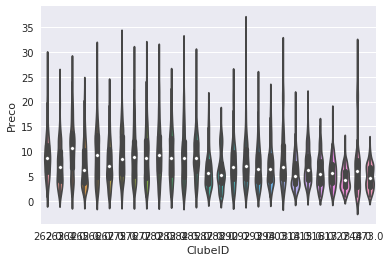

In [19]:
ax = sns.violinplot(data = jogaram_all_years, x='ClubeID', y="Preco")

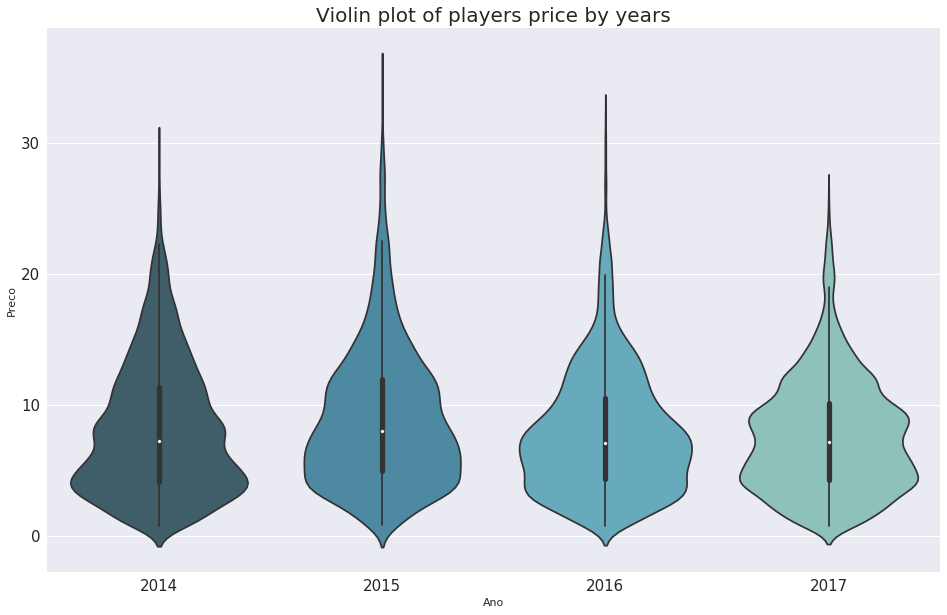

In [20]:
fig, ax = plt.subplots()
fig.set_size_inches(16,10)
vis = sns.violinplot(data = jogaram_all_years, x='Ano', y="Preco", palette="GnBu_d")
vis.set(yticks=np.arange(0,40,10))
vis.axes.set_title('Violin plot of players price by years',fontsize=20)
vis.tick_params(labelsize=15)
plt.show()


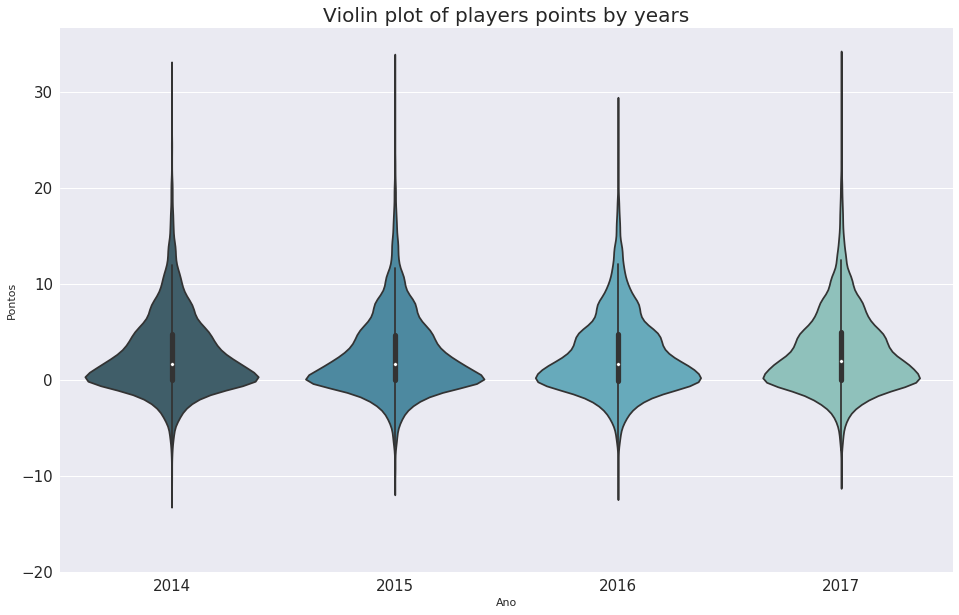

In [21]:
fig, ax = plt.subplots()
fig.set_size_inches(16,10)
vis = sns.violinplot(data = jogaram_all_years, x='Ano', y="Pontos", palette="GnBu_d")
vis.set(yticks=np.arange(-20,40,10))
vis.axes.set_title('Violin plot of players points by years',fontsize=20)
vis.tick_params(labelsize=15)
plt.show()

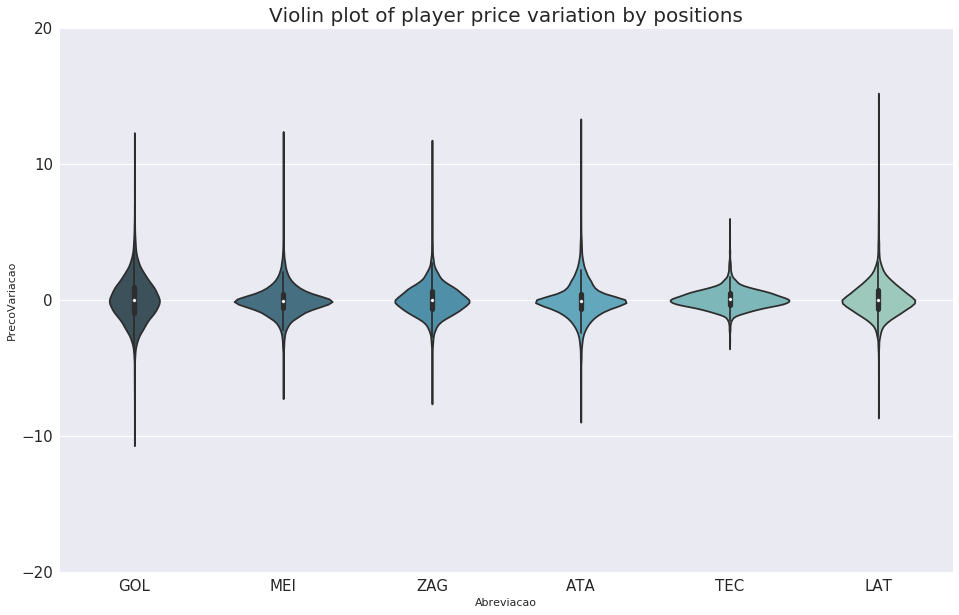

In [22]:
fig, ax = plt.subplots()
fig.set_size_inches(16,10)
vis = sns.violinplot(data = jogaram_all_years, x='Abreviacao', y="PrecoVariacao", palette="GnBu_d")
vis.set(yticks=np.arange(-20,30,10))
vis.axes.set_title('Violin plot of player price variation by positions',fontsize=20)
vis.tick_params(labelsize=15)
plt.show()



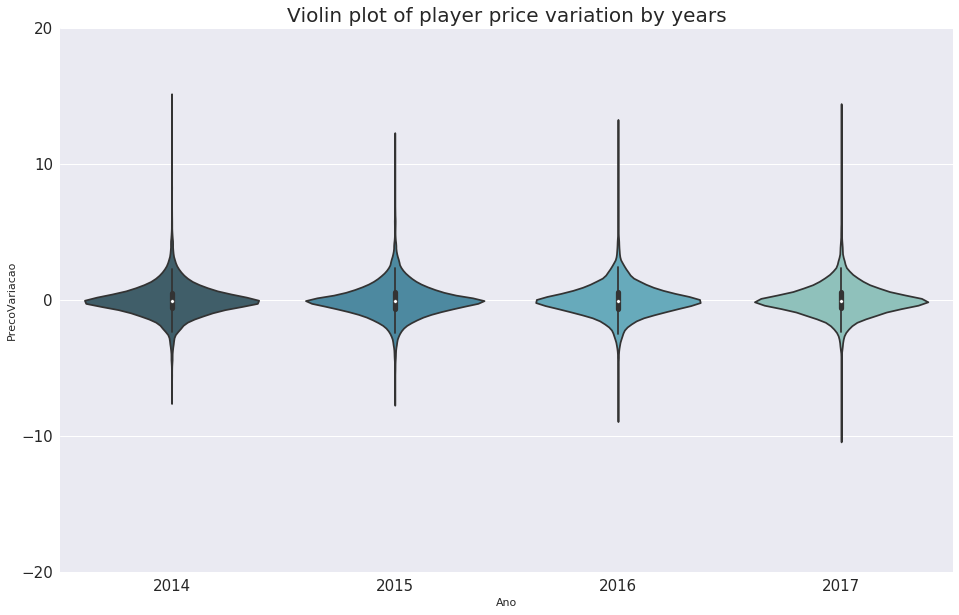

In [23]:
fig, ax = plt.subplots()
fig.set_size_inches(16,10)
vis = sns.violinplot(data = jogaram_all_years, x='Ano', y="PrecoVariacao", palette="GnBu_d")
vis.set(yticks=np.arange(-20,30,10))
vis.axes.set_title('Violin plot of player price variation by years',fontsize=20)
vis.tick_params(labelsize=15)
plt.show()

In [24]:
jogaram_all_years.groupby(['ClubeID','Ano']).mean().reset_index().head(10)

,ClubeID,Ano,Rodada,AtletaID,Participou,Pontos,PontosMedia,Preco,PrecoVariacao,FS,...,RB,FC,GC,CA,CV,SG,DD,DP,GS,PosicaoID
0,262.0,2014,19.737500,62406.694643,True,2.779857,2.685018,8.073893,-0.052036,0.928571,...,0.982143,1.048214,0.000000,0.119643,0.007143,0.105357,0.101786,0.003571,0.083929,3.658929
1,262.0,2015,18.986965,67778.191806,True,2.581713,2.506890,8.905978,-0.027412,12.333333,...,11.204842,11.426443,0.100559,1.919926,0.119181,1.145251,0.756052,0.000000,1.001862,3.711359
2,262.0,2016,19.371886,69475.081851,True,3.520302,3.728452,10.008274,0.064288,1.032028,...,0.937722,0.852313,0.001779,0.110320,0.008897,0.149466,0.112100,0.000000,0.062278,3.701068
3,262.0,2017,19.851986,68684.620939,True,3.267112,3.254477,8.696137,-0.065469,12.001805,...,12.379061,11.859206,0.019856,1.330325,0.036101,1.413357,0.554152,0.019856,0.561372,3.682310
4,263.0,2014,19.989130,60286.528986,True,2.166467,2.064656,6.362464,-0.035072,1.076087,...,0.827899,1.085145,0.001812,0.155797,0.016304,0.092391,0.123188,0.000000,0.083333,3.751812
5,263.0,2016,19.013133,74837.765478,True,3.072026,3.130113,7.114409,0.077054,0.971857,...,1.028143,1.024390,0.001876,0.165103,0.003752,0.136961,0.101313,0.003752,0.071295,3.735460
6,263.0,2017,19.830935,77284.696043,True,3.294299,3.421835,8.388471,0.028399,12.974820,...,14.638489,13.996403,0.028777,2.154676,0.019784,1.917266,1.526978,0.143885,1.000000,3.660072
7,264.0,2014,19.408377,58757.553229,True,3.181361,3.279529,11.273316,0.019756,1.101222,...,0.888307,0.954625,0.003490,0.122164,0.005236,0.136126,0.054101,0.001745,0.054101,3.724258
8,264.0,2015,18.590494,56332.338208,True,3.669927,3.473711,11.850530,0.015631,9.409506,...,9.888483,8.349177,0.000000,1.495430,0.065814,2.053016,1.685558,0.003656,0.897623,3.700183
9,264.0,2016,19.461121,65478.426763,True,2.846383,3.173436,9.708354,-0.054033,0.983725,...,0.864376,0.985533,0.001808,0.135624,0.009042,0.124774,0.074141,0.001808,0.075949,3.634720


### GENERATING TABLES WITH ATHLETES

In [25]:
atletas_all_years = atletas_all_years.drop_duplicates(['ID'])

In [26]:
atletas_all_years.head()

,ID,Apelido,ClubeID,PosicaoID,Ano
0,80583,Lucas Lima,277,4,2014
1,72079,Bruno Cortez,288,2,2014
2,86189,Mosquito,293,5,2014
3,68938,Giovanni Augusto,316,4,2014
4,68974,Marcão,316,5,2014


In [27]:
clubes_all_years.head()

,ID,Nome,Abreviacao,Slug
0,262,Flamengo,FLA,flamengo
1,263,Botafogo,BOT,botafogo
2,264,Corinthians,COR,corinthians
3,265,Bahia,BAH,bahia
4,266,Fluminense,FLU,fluminense


In [28]:
posicoes_all_years

,ID,Nome,Abreviacao
0,1,Goleiro,GOL
1,2,Lateral,LAT
2,3,Zagueiro,ZAG
3,4,Meia,MEI
4,5,Atacante,ATA
5,6,Técnico,TEC


In [29]:
atletas_all_years = atletas_all_years.merge(clubes_all_years[['ID','Abreviacao','Nome']], how='inner', left_on='ClubeID',\
                         right_on='ID')

atletas_all_years = atletas_all_years.merge(posicoes_all_years[['ID','Abreviacao']], how='inner', left_on='PosicaoID',\
                         right_on='ID')

atletas_all_years = atletas_all_years.drop(labels=['ID_y','ID'], axis = 1)

In [30]:
atletas_all_years = atletas_all_years.rename(columns={'ID_x':'ID_jogador','Nome':'nome_clube','Abreviacao_x':'abrev_clube',\
                                                     'Abreviacao_y':'posicao'})

In [31]:
atletas_all_years = atletas_all_years.drop_duplicates(['ID_jogador'])

In [32]:
atletas_all_years.head()

,ID_jogador,Apelido,ClubeID,PosicaoID,Ano,abrev_clube,nome_clube,posicao
0,80583,Lucas Lima,277,4,2014,SAN,Santos,MEI
2,88002,Serginho,277,4,2014,SAN,Santos,MEI
4,70132,Alan Santos,277,4,2014,SAN,Santos,MEI
6,78235,Leandrinho,277,4,2014,SAN,Santos,MEI
8,89637,Thiago Maia,277,4,2014,SAN,Santos,MEI


In [33]:
atletas_all_years = atletas_all_years.drop_duplicates()

In [34]:
atletas_all_years.to_csv('atletas_all_years.csv', sep='\t')

In [35]:
scouts_all_years.head()

,Rodada,ClubeID,AtletaID,Participou,Pontos,PontosMedia,Preco,PrecoVariacao,FS,PE,...,CA,CV,SG,DD,DP,GS,Ano,Apelido,PosicaoID,Abreviacao
0,0,285.0,36443,False,0.0,0.00,9.00,0.00,0,0,...,0,0,0,0,0,0,2014,Dida,1,GOL
1,1,285.0,36443,True,5.0,5.00,10.60,1.60,0,0,...,0,0,1,0,0,0,2014,Dida,1,GOL
2,2,285.0,36443,True,-3.0,1.00,8.27,-2.33,2,0,...,0,0,0,0,0,2,2014,Dida,1,GOL
3,3,285.0,36443,True,-2.6,-0.20,6.81,-1.46,0,2,...,0,0,0,0,0,1,2014,Dida,1,GOL
4,4,285.0,36443,True,4.0,0.85,7.96,1.15,0,0,...,0,0,0,2,0,1,2014,Dida,1,GOL


### GERANDO PONTUAÇÃO DOS CLUBES RODADA A RODADA

In [36]:


treinadores = atletas_all_years.ID_jogador[atletas_all_years.PosicaoID == 6]

cols1 = ['Ano','Rodada', 'ClubeID', 'AtletaID', 'Participou', 'Pontos']
tabela_cartola = scouts_all_years[scouts_all_years.AtletaID.isin(treinadores)][cols1]

cols2 = ['Ano','Rodada', 'ClubeID', 'AtletaID', 'Participou', 'Pontos', 'Abreviacao']
tabela_cartola = tabela_cartola.merge(clubes_all_years[['ID','Abreviacao','Nome']], how='inner', left_on='ClubeID',\
                         right_on='ID')[cols2]

cols3 = ['Ano','Rodada', 'ClubeID', 'AtletaID', 'Apelido','Participou', 'Pontos', 'Abreviacao']
tabela_cartola = tabela_cartola.merge(atletas_all_years[['ID_jogador','Apelido']], how='inner', left_on='AtletaID',\
                         right_on='ID_jogador')[cols3]

tabela_cartola = tabela_cartola.sort_values(by=['Ano', 'ClubeID', 'Rodada'])

tabela_cartola['Apelido'] = tabela_cartola.apply(lambda x: str(x.Apelido).lower(), axis=1)

tabela_cartola = tabela_cartola.drop_duplicates()

tabela_cartola

,Ano,Rodada,ClubeID,AtletaID,Apelido,Participou,Pontos,Abreviacao
4795,2014,0,262,79019,jayme de almeida,False,0.00,FLA
4797,2014,1,262,79019,jayme de almeida,True,2.35,FLA
4799,2014,2,262,79019,jayme de almeida,True,1.59,FLA
4801,2014,3,262,79019,jayme de almeida,True,5.79,FLA
4803,2014,4,262,79019,jayme de almeida,True,0.16,FLA
4641,2014,11,262,41327,vanderlei luxemburgo,False,0.00,FLA
4643,2014,12,262,41327,vanderlei luxemburgo,True,4.39,FLA
4645,2014,13,262,41327,vanderlei luxemburgo,True,1.65,FLA
4647,2014,14,262,41327,vanderlei luxemburgo,True,4.30,FLA
4649,2014,15,262,41327,vanderlei luxemburgo,True,3.87,FLA


In [37]:
tabela_quase_final = pd.DataFrame(tabela_cartola.groupby(['Ano','Abreviacao'])['Pontos'].mean())
tabela_final = tabela_quase_final.reset_index().sort_values(by=['Ano','Pontos'], ascending = [True, False])
tabela_final

,Ano,Abreviacao,Pontos
8,2014,CRU,4.189744
6,2014,COR,3.890256
14,2014,INT,3.827179
17,2014,SAO,3.664103
16,2014,SAN,3.624717
2,2014,CAM,3.485500
10,2014,FLA,3.440000
13,2014,GRE,3.286552
12,2014,GOI,3.276579
11,2014,FLU,3.163333


In [38]:
tabela

,Ano,abrev_clube_casa,pts_casa,pts_fora,pts_total
8,2014,CRU,47,33,80
17,2014,SAO,39,31,70
6,2014,COR,42,27,69
14,2014,INT,45,24,69
2,2014,CAM,41,21,62
11,2014,FLU,39,22,61
13,2014,GRE,40,21,61
3,2014,CAP,35,19,54
16,2014,SAN,33,20,53
10,2014,FLA,35,17,52


In [39]:
cols_final = ['Ano', 'Abreviacao', 'pts_total', 'Pontos']
tabela_unificada = tabela.merge(tabela_final, how = 'inner', left_on = ['Ano','abrev_clube_casa'], right_on=['Ano','Abreviacao'])[cols_final]
tabela_unificada = tabela_unificada.rename(columns={'pts_total':'pts_real','Pontos':'pts_cartola'})
tabela_unificada

,Ano,Abreviacao,pts_real,pts_cartola
0,2014,CRU,80,4.189744
1,2014,SAO,70,3.664103
2,2014,COR,69,3.890256
3,2014,INT,69,3.827179
4,2014,CAM,62,3.485500
5,2014,FLU,61,3.163333
6,2014,GRE,61,3.286552
7,2014,CAP,54,2.643182
8,2014,SAN,53,3.624717
9,2014,FLA,52,3.440000


# Exploratory Data Analysis

### Plot of .....

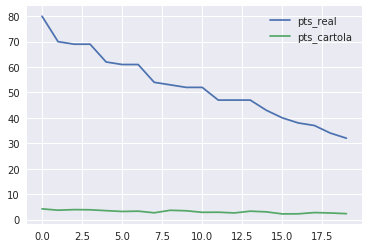

In [40]:
tabela_unificada[['pts_real','pts_cartola']][tabela_unificada.Ano==2014].plot()

In [41]:
atletas_all_years.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2242 entries, 0 to 3973
Data columns (total 8 columns):
ID_jogador     2242 non-null int64
Apelido        2242 non-null object
ClubeID        2242 non-null int64
PosicaoID      2242 non-null int64
Ano            2242 non-null int64
abrev_clube    2242 non-null object
nome_clube     2242 non-null object
posicao        2242 non-null object
dtypes: int64(4), object(4)
memory usage: 237.6+ KB


In [42]:
partidas_all_years.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1520 entries, 0 to 379
Data columns (total 8 columns):
Ano                1520 non-null int64
CasaID             1520 non-null int64
ID                 1520 non-null int64
PlacarCasa         1519 non-null float64
PlacarVisitante    1519 non-null float64
Resultado          1139 non-null object
Rodada             1520 non-null int64
VisitanteID        1520 non-null int64
dtypes: float64(2), int64(5), object(1)
memory usage: 106.9+ KB


### Joint Distribution ClubeID x PosicaoID


In [43]:
atletas_all_years.head()

,ID_jogador,Apelido,ClubeID,PosicaoID,Ano,abrev_clube,nome_clube,posicao
0,80583,Lucas Lima,277,4,2014,SAN,Santos,MEI
2,88002,Serginho,277,4,2014,SAN,Santos,MEI
4,70132,Alan Santos,277,4,2014,SAN,Santos,MEI
6,78235,Leandrinho,277,4,2014,SAN,Santos,MEI
8,89637,Thiago Maia,277,4,2014,SAN,Santos,MEI


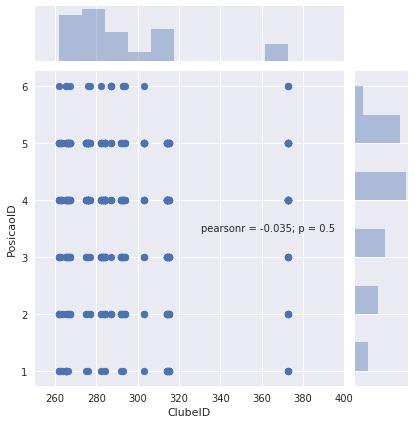

In [44]:
sns.jointplot(x="ClubeID", y="PosicaoID", data=atletas_all_years[atletas_all_years.Ano == 2017], size=6, xlim=[250,400]);

Here we plot the joint plot of ClubeID (teams) and PositionID (players positions in field)


Notice that:

* We have more players on "MEIA" position 
* The team with more players is the one with ClubeID nearest 260.

### Histogram (number of observations for each value on each columns) of Athletes_all_years table

OBS: PosicaoID é a posição do jogador em campo (1 = zagueiro, 2 = lateral, ..., 5 = atacante, 6 = técnico)

In [45]:
atletas_all_years.head()

,ID_jogador,Apelido,ClubeID,PosicaoID,Ano,abrev_clube,nome_clube,posicao
0,80583,Lucas Lima,277,4,2014,SAN,Santos,MEI
2,88002,Serginho,277,4,2014,SAN,Santos,MEI
4,70132,Alan Santos,277,4,2014,SAN,Santos,MEI
6,78235,Leandrinho,277,4,2014,SAN,Santos,MEI
8,89637,Thiago Maia,277,4,2014,SAN,Santos,MEI


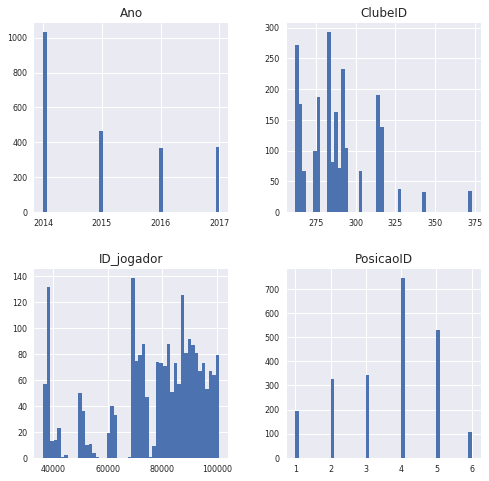

In [46]:
atletas_all_years.hist(figsize=(8, 8), bins=50, xlabelsize=8, ylabelsize=8);

In [47]:
atletas_all_years.sample(10).sort_values("ID_jogador")

,ID_jogador,Apelido,ClubeID,PosicaoID,Ano,abrev_clube,nome_clube,posicao
2866,68872,Marcelo Lomba,265,1,2014,BAH,Bahia,GOL
3586,68900,Geovane Maranhão,263,5,2016,BOT,Botafogo,ATA
1365,68908,Gualberto,288,3,2014,CRI,Criciúma,ZAG
3169,69048,Mazola,316,5,2014,FIG,Figueirense,ATA
2969,78584,Douglas Friedrich,264,1,2016,COR,Corinthians,GOL
1150,85403,Daniel,282,4,2014,CAM,Atlético-MG,MEI
3327,87197,Matheus,315,5,2015,CHA,Chapecoense,ATA
3720,92081,Richarlison,266,5,2016,FLU,Fluminense,ATA
2540,99880,Kelly,293,6,2017,CAP,Atlético-PR,TEC
2206,100158,Lucas Soares,283,2,2017,CRU,Cruzeiro,LAT


### Interactive Plots on TABLEAU

* Number of Players,with positions, by year: [link](https://public.tableau.com/profile/renato.aranha#!/vizhome/qtd_jog_por_posicao/Planilha1)
